In [ ]:
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.optim as optim
from torch.optim import lr_scheduler

In [65]:
# Путь к папке с данными
data_path = 'dataset'

# Собираем все CSV-файлы
# Оставил 2000 чтобы не тратить много времени на ожидание. Тестовое все же.
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')][:2000]

In [72]:
# Чтение и объединение всех CSV в один DataFrame
df = pd.concat([pd.read_csv(os.path.join(data_path, f)) for f in csv_files], ignore_index=True)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,000106393cfe2343888c584e65fd2274,3520,2514,F16,0,0,1796,1451
1,0002f2cc10d90392efc3ad30cbda6490,3793,1702,H6,1438,1090,1524,1181
2,0002f2cc10d90392efc3ad30cbda6490,3793,1702,H6,748,888,834,979
3,0002f2cc10d90392efc3ad30cbda6490,3793,1702,H6,2469,596,2551,674
4,0002f2cc10d90392efc3ad30cbda6490,3793,1702,H6,648,863,735,953


In [73]:
# Оставляю 10 самых популярных классов, тоже чтобы тратить меньше времени
top_classes = df['class'].value_counts().index[:10]

# Оставляем только те строки, где класс входит в 8 самых популярных
df = df[df['class'].isin(top_classes)]

# Выводим количество строк по классам
print(df['class'].value_counts())


class
F18     192
F16     179
F35     158
F15     152
C130    121
V22      99
US2      98
F14      96
J10      92
F4       84
Name: count, dtype: int64


In [74]:
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])

LabelEncoder()

In [49]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.dataframe.iloc[idx, 0]}.jpg")
        image = Image.open(img_name)
        xmin = self.dataframe.iloc[idx, 4]
        ymin = self.dataframe.iloc[idx, 5]
        xmax = self.dataframe.iloc[idx, 6]
        ymax = self.dataframe.iloc[idx, 7]

        image = image.crop((xmin, ymin, xmax, ymax))

        label = self.dataframe.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label


In [50]:
# Функция для обработки данных (преобразования и разделения на выборки)
def prepare_data(df, img_dir='dataset', test_size=0.3, val_size=0.33):
    # Инициализируем LabelEncoder
    label_encoder = LabelEncoder()
    df['class'] = label_encoder.fit_transform(df['class'])

    # Разделяем данные на тренировочные, валидационные и тестовые выборки
    train_df, temp_df = train_test_split(df, test_size=test_size, stratify=df['class'])
    val_df, test_df = train_test_split(temp_df, test_size=val_size, stratify=temp_df['class'])
    
    # Создаем преобразования для изображений
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB')),  # Преобразуем в RGB (игнорируя альфа-канал)
        transforms.RandomHorizontalFlip(),  # Отражение
        transforms.RandomRotation(30),  # Случайный поворот
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Изменение яркости
        transforms.Resize((128, 128)),  # Приводим все изображения к размеру 128x128
        transforms.ToTensor(),  # Преобразование в Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
    ])

    # Создаем CustomDataset для каждого набора данных
    train_dataset = CustomDataset(train_df, img_dir=img_dir, transform=transform)
    val_dataset = CustomDataset(val_df, img_dir=img_dir, transform=transform)
    test_dataset = CustomDataset(test_df, img_dir=img_dir, transform=transform)

    return train_dataset, val_dataset, test_dataset

# Функция для загрузки модели
def load_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    # Замораживаем все слои, кроме последнего
    for param in model.parameters():
        param.requires_grad = False
    
    # Заменяем последний слой для количества классов
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    
    return model

# Функция для обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20, patience=5):
    # Ранняя остановка
    best_loss = np.inf
    epochs_without_improvement = 0
    
    # Массивы для лоссов и точности
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Обучение
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy:.2f}%")

        # Валидация
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Ранняя остановка: если потери на валидации не уменьшаются
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Обновляем learning rate на основе результатов валидации
        scheduler.step(val_loss)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Функция для валидации модели
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    return val_loss / len(val_loader), val_accuracy

In [51]:
# Подготовка данных
train_dataset, val_dataset, test_dataset = prepare_data(df, img_dir='dataset')

# Загрузка модели
model = load_model(num_classes=len(df['class'].unique()))

# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Обучение модели
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20
)

c:\Users\oplet\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\oplet\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\oplet\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 2.2779, Accuracy: 17.66%
Validation Loss: 2.1067, Validation Accuracy: 20.78%
Epoch [2/20], Loss: 1.9797, Accuracy: 31.38%
Validation Loss: 2.0173, Validation Accuracy: 32.55%
Epoch [3/20], Loss: 1.8183, Accuracy: 38.47%
Validation Loss: 1.9406, Validation Accuracy: 31.37%
Epoch [4/20], Loss: 1.7182, Accuracy: 42.74%
Validation Loss: 1.8109, Validation Accuracy: 41.18%
Epoch [5/20], Loss: 1.6475, Accuracy: 46.01%
Validation Loss: 1.8678, Validation Accuracy: 39.22%
Epoch [6/20], Loss: 1.5677, Accuracy: 46.46%
Validation Loss: 1.7890, Validation Accuracy: 41.18%
Epoch [7/20], Loss: 1.5990, Accuracy: 46.12%
Validation Loss: 1.7780, Validation Accuracy: 37.65%
Epoch [8/20], Loss: 1.5109, Accuracy: 46.79%
Validation Loss: 1.8081, Validation Accuracy: 38.04%
Epoch [9/20], Loss: 1.4917, Accuracy: 48.71%
Validation Loss: 1.7741, Validation Accuracy: 43.14%
Epoch [10/20], Loss: 1.5245, Accuracy: 48.48%
Validation Loss: 1.7599, Validation Accuracy: 44.31%
Epoch [11/20], Loss

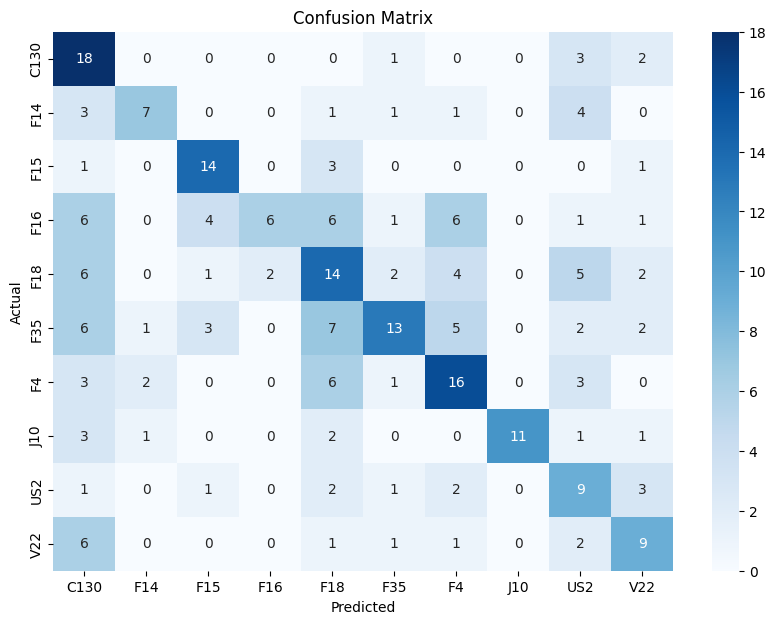

              precision    recall  f1-score   support

        C130       0.34      0.75      0.47        24
         F14       0.64      0.41      0.50        17
         F15       0.61      0.74      0.67        19
         F16       0.75      0.19      0.31        31
         F18       0.33      0.39      0.36        36
         F35       0.62      0.33      0.43        39
          F4       0.46      0.52      0.48        31
         J10       1.00      0.58      0.73        19
         US2       0.30      0.47      0.37        19
         V22       0.43      0.45      0.44        20

    accuracy                           0.46       255
   macro avg       0.55      0.48      0.48       255
weighted avg       0.54      0.46      0.46       255



In [75]:
# Получаем прогнозы для валидационного набора данных
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Рассчитываем confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Выводим confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Рассчитываем точность, precision, recall и f1-score
report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_.astype(str))
print(report)


В целом результаты получились достаточно неплохие. Но заметно переообучение на самолете C130 и F18. Если F18 просто встречается чаще остальных, то C130 скорее всего просто занимает очень много места на экране, чем путает модель. Самолеты F16, F18 и F35 тоже часто путались друг с другом, но они в самом деле похожи друг на друга, еще и одного цвета.

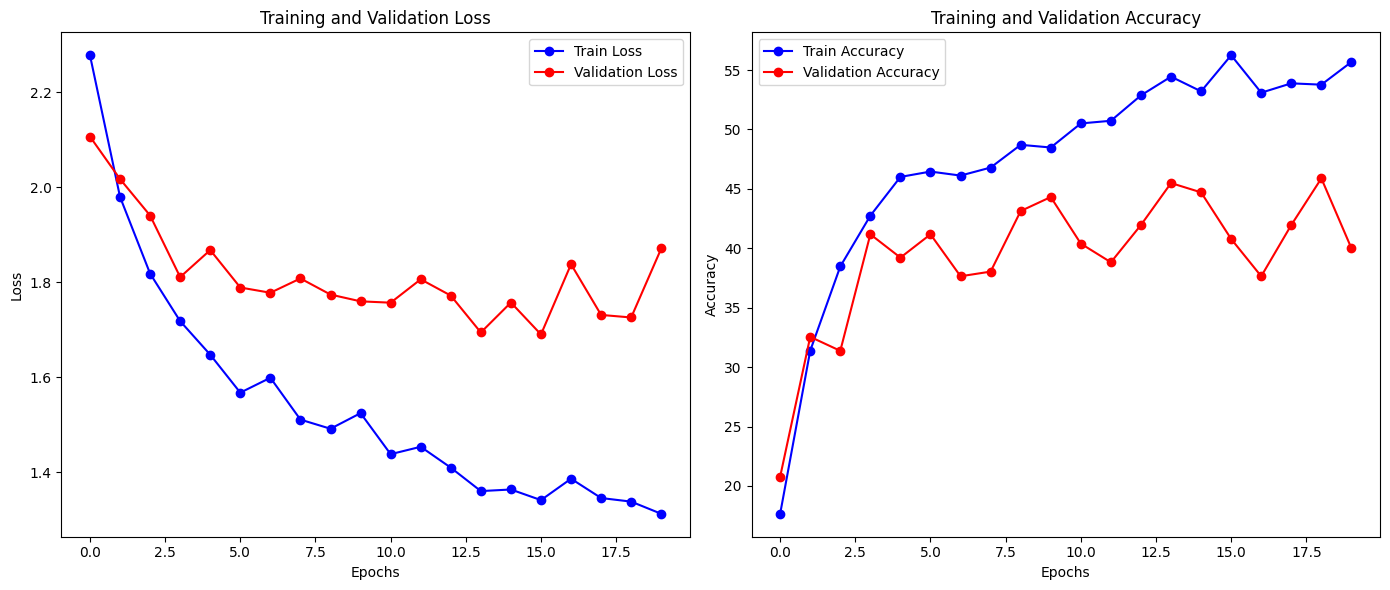

In [56]:
# Создание первого графика (Losses)
plt.figure(figsize=(14, 6))

# Потери на обучении и валидации
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='-', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Создание второго графика (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', color='red', linestyle='-', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Модель стремится к переобучению начиная с 10 эпохи. Точность валидации достаточно волатильна на всем диапазоне измерений. В дальшей работе я бы уменьшил скорость обучения.

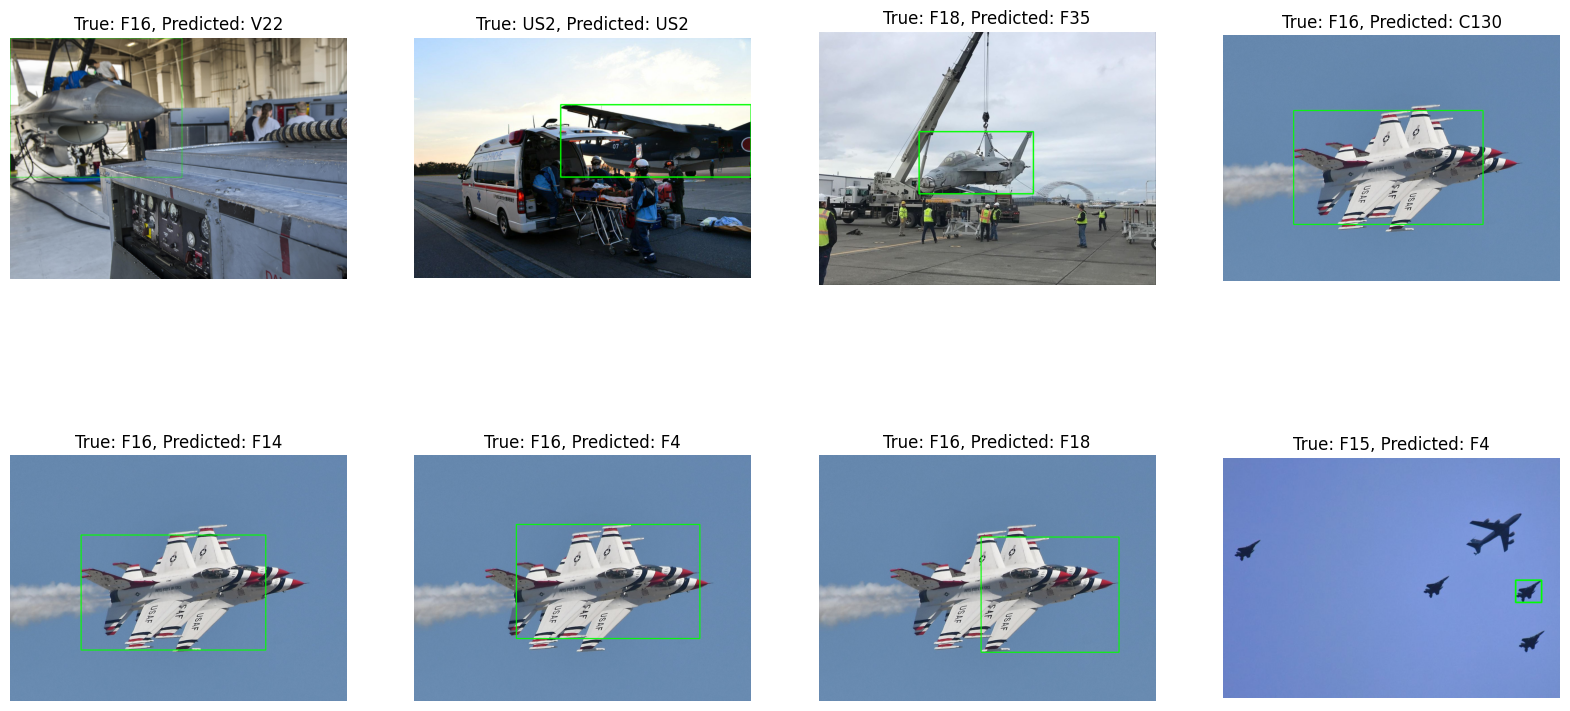

In [85]:
# Получаем прогнозы для валидационного набора данных
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Найдем индексы ошибок
incorrect_predictions = []
for i, (label, pred) in enumerate(zip(all_labels, all_predictions)):
    # Преобразуем числовые метки обратно в строковые значения
    true_class = label_encoder.inverse_transform([label])[0]
    predicted_class = label_encoder.inverse_transform([pred])[0]

    if true_class != predicted_class:
        incorrect_predictions.append(i)

# Путь к изображениям (измените путь, если необходимо)
data_path = 'dataset'

plt.figure(figsize=(20, 10))

for i, idx in enumerate(incorrect_predictions[:8]):
    image_path = os.path.join(data_path, f'{df.iloc[idx]["filename"]}.jpg')
    image = cv2.imread(image_path)

    # Получаем координаты для рисования прямоугольника
    xmin = df.iloc[idx]['xmin']
    ymin = df.iloc[idx]['ymin']
    xmax = df.iloc[idx]['xmax']
    ymax = df.iloc[idx]['ymax']

    # Рисуем прямоугольник на изображении
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

    # Преобразуем изображение из BGR в RGB для отображения
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, i + 1)
    true_class = df.iloc[idx]['class']
    predicted_class = label_encoder.inverse_transform([all_predictions[idx]])[0]
    plt.imshow(image_rgb)
    plt.title(f"True: {true_class}, Predicted: {predicted_class}")
    plt.axis('off')

plt.show()


Как видно, на данных фото очень сложно что-то распознать, даже разбираясь в самолетах. Помимо этого, 4, 5 и 6 изображение скорее всего содержит ошибки разметки. Самолеты выглядят одинаково, но помечены как разные. 